# Yargy

Yargy — библиотека для извлечения структурированной информации из текстов на русском языке. Правила описываются контекстно-свободными грамматиками и словарями ключевых слов. Банк готовых правил для имён, дат, адресов и других сущностей доступен в репозитории [Natasha](https://github.com/natasha/natasha).

Для работы с морфологией используется [Pymorphy2](http://pymorphy2.readthedocs.io/en/latest/). Парсер реализует алгоритм [Earley parser](https://en.wikipedia.org/wiki/Earley_parser). Библиотека написана на чистом Питоне, поддерживает Python 2.7+ / 3.4+ и Pypy.

Чем Yargy отличается от [Томита-парсера](https://tech.yandex.ru/tomita/)? Эти инструменты решают одну задачу — извлечение информации из текстов на естественном языке. Томита-парсер много лет разрабатывался внутри Яндекса, объём кода — десятки тысяч строк на C++. Yargy — библиотека созданная сообществом, написанная на Питоне, объём кода — несколько тысяч строк. У этих проектов очень много отличий, вот основные:

  - У Томита-парсера консольный интерфейс, Yargy — это библиотека на Питоне
  - В Томита-парсере для описания правил используется свой язык и Protobuf-файлы, в Yargy грамматики и словари описываются на Питоне
  - Вместе с Yargy в репозитории [Natasha](https://github.com/natasha/natasha) публикуются готовые правила для извлечения имён, дат, адресов и других сущностей. Яндекс не раскрывает свои правила для Томита-парсера.
  - Томита-парсер — не очень быстрый, Yargy — вообще не очень быстрый, потому что реализован на Питоне, а не на C++ и, наверняка, не так хорошо оптимизирован, как Томита-парсер.

## Примеры

Yargy заточен под работу с естественными текстами на русском языке, но основа библиотеки — обычный [GLR-парсер](https://en.wikipedia.org/wiki/GLR_parser). Ничего не мешает написать, например, парсер простых математических выражений:

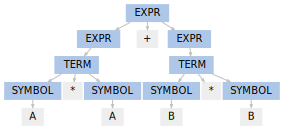

In [1]:
from yargy import Parser, rule, or_, forward
from yargy.predicates import in_


SYMBOL = rule(
    in_('AB')
).named('SYMBOL')
TERM = rule(
    SYMBOL,
    in_('/*'),
    SYMBOL
).named('TERM')
EXPR = forward()
EXPR.define(or_(
    SYMBOL,
    TERM,
    rule(
        EXPR,
        in_('+-'),
        EXPR
    )
).named('EXPR'))


parser = Parser(EXPR)
match = parser.match('A * A + B * B')
match.tree.as_dot

Для работы с русским языком в Yargy встроен морфологический анализатор [Pymorphy2](http://pymorphy2.readthedocs.io/en/latest/). Можно, например, извлечь из текста топонимы, которые начинаются прилагательным и заканчиваются словами "федерация" или "республика". Например, "Российская Федерация", "Донецкая народная республика":

In [2]:
from yargy import Parser, rule, and_
from yargy.predicates import gram, is_capitalized, dictionary


GEO = rule(
    and_(
        gram('ADJF'),  # так помечается прилагательное, остальные пометки описаны в
                       # http://pymorphy2.readthedocs.io/en/latest/user/grammemes.html
        is_capitalized()
    ),
    gram('ADJF').optional().repeatable(),
    dictionary({
        'федерация',
        'республика'
    })
)


parser = Parser(GEO)
text = '''
В Чеченской республике на день рождения ...
Донецкая народная республика провозгласила ...
Башня Федерация — одна из самых высоких ...
'''
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['Донецкая', 'народная', 'республика']
['Чеченской', 'республике']


Настоящие сложные грамматики для топонимов собраны в репозитории [Natasha](https://github.com/natasha/natasha)

Часто найти подстроку в тексте не достаточно, нужно разбить информацию на поля и нормализовать. Например, из предложения "12 марта по приказу президента Владимира Путина ...", извлекается не просто три слова "президента Владимира Путина", а объект вида `Person(position='президент', Name(first='Владимир', last='Путин'))`.

In [3]:
from yargy import Parser
from yargy.predicates import gram
from yargy.pipelines import morph_pipeline
from yargy.interpretation import fact
from IPython.display import display

Person = fact(
    'Person',
    ['position', 'name']
)
Name = fact(
    'Name',
    ['first', 'last']
)


POSITION = morph_pipeline([
    'премьер министр',
    'президент'
])

NAME = rule(
    gram('Name').interpretation(
        Name.first.inflected()
    ),
    gram('Surn').interpretation(
        Name.last.inflected()
    )
).interpretation(
    Name
)

PERSON = rule(
    POSITION.interpretation(
        Person.position.inflected()
    ),
    NAME.interpretation(
        Person.name
    )
).interpretation(
    Person
)


parser = Parser(PERSON)
text = '''
12 марта по приказу президента Владимира Путина ...
'''
for match in parser.findall(text):
    display(match.fact)

Person(position='президент',
       name=Name(first='владимир',
                 last='путин'))

Полные грамматики для имён и должностей собраны в репозитории [Natasha](https://github.com/natasha/natasha)

## Токенизатор

In [4]:
from yargy.tokenizer import MorphTokenizer


tokenizer = MorphTokenizer()
text = '''Ростов-на-Дону
Длительностью 18ч. 10мин.
Яндекс.Такси
π ≈ 3.1415
1 500 000$
http://vk.com
'''
for line in text.splitlines():
    print([_.value for _ in tokenizer(line)])

['Ростов', '-', 'на', '-', 'Дону']
['Длительностью', '18', 'ч', '.', '10', 'мин', '.']
['Яндекс', '.', 'Такси']
['π', '≈', '3', '.', '1415']
['1', '500', '000', '$']
['http', ':', '/', '/', 'vk', '.', 'com']


Для каждого токена делается морфологический анализ, определяется набор граммем. Например, "NOUN, sing, femn" означает "существительное в единственном числе женского рода". Вне контекста слово может иметь несколько вариантов разбора, например, "стали" может быть существительным (NOUN), как в "марки стали", а может быть глаголом (VERB), как в "мы стали лучше":

In [5]:
tokenizer = MorphTokenizer()
list(tokenizer('марки стали'))

[MorphToken('марки',
            [0, 5),
            'RU',
            [Form('марка', Grams(NOUN,femn,gent,inan,sing)),
             Form('марка', Grams(NOUN,femn,inan,nomn,plur)),
             Form('марка', Grams(NOUN,accs,femn,inan,plur)),
             Form('маркий', Grams(ADJS,Qual,plur)),
             Form('марк', Grams(NOUN,Name,anim,masc,nomn,plur))]),
 MorphToken('стали',
            [6, 11),
            'RU',
            [Form('стать', Grams(VERB,indc,intr,past,perf,plur)),
             Form('сталь', Grams(NOUN,femn,gent,inan,sing)),
             Form('сталь', Grams(NOUN,femn,inan,nomn,plur)),
             Form('сталь', Grams(NOUN,datv,femn,inan,sing)),
             Form('сталь', Grams(NOUN,femn,inan,loct,sing)),
             Form('сталь', Grams(NOUN,accs,femn,inan,plur))])]

## Газеттир

Газеттир нужен для удобной работы с последовательностью слов. Например, можно написать:

In [6]:
from yargy import or_, rule
from yargy.predicates import normalized

RULE = or_(
    rule(normalized('dvd'), '-', normalized('диск')),
    rule(normalized('видео'), normalized('файл'))
)

In [7]:
from yargy import Parser
from yargy.pipelines import morph_pipeline


RULE = morph_pipeline([
    'dvd-диск',
    'видео файл',
    'видеофильм',
    'газета',
    'электронный дневник',
    'эссе',
])

parser = Parser(RULE)
text = 'Видео файл на dvd-диске'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['dvd', '-', 'диске']
['Видео', 'файл']


## Предикаты

In [8]:
from yargy import and_, not_
from yargy.tokenizer import MorphTokenizer
from yargy.predicates import is_capitalized, eq


tokenizer = MorphTokenizer()
token = next(tokenizer('Стали'))

predicate = is_capitalized()
assert predicate(token) == True

predicate = and_(
    is_capitalized(),
    not_(eq('марки'))
)
assert predicate(token) == True

In [9]:
from pymorphy2.shapes import is_roman_number

from yargy.tokenizer import Tokenizer
from yargy.predicates import custom


tokenizer = Tokenizer()
token = next(tokenizer('XL'))

predicate = custom(is_roman_number, types='LATIN')
predicate = predicate.activate(tokenizer)  # проверяется, что tokenizer поддерживает тип 'LATIN'
assert predicate(token) == True

token = next(tokenizer('XS'))
assert predicate(token) == False

## Грамматики

В Yargy используется специальный DSL для описания грамматик. Любую контекстно-свободную грамматику можно описать с помощью конструкций Питона. Например, есть примитивная грамматика для размеров одежды:
```
KEY -> р. | размер
VALUE -> S | M | L
SIZE -> KEY VALUE
```
Вот так она будет выглядеть в Yargy:

In [10]:
from yargy import rule, or_


KEY = or_(
    rule('р', '.'),
    rule('размер')
).named('KEY')
VALUE = or_(
    rule('S'),
    rule('M'),
    rule('L'),
).named('VALUE')
SIZE = rule(
    KEY,
    VALUE
).named('SIZE')
SIZE.normalized.as_bnf

SIZE -> KEY VALUE
KEY -> 'р' '.' | 'размер'
VALUE -> 'S' | 'M' | 'L'


Терминалом может быть не константа, а предикат. Например, правило для `VALUE` лучше записать так:

In [11]:
from yargy.predicates import in_


VALUE = rule(
    in_('SML')
).named('VALUE')
SIZE = rule(
    KEY,
    VALUE
).named('SIZE')
SIZE.normalized.as_bnf

SIZE -> KEY VALUE
KEY -> 'р' '.' | 'размер'
VALUE -> in_(...)


Как быть, когда правая часть правила ссылается на левую? Например, так:
```
EXPR -> a | ( EXPR + EXPR )
```
В Питоне нельзя использовать, переменные, которые ещё не объявлены. Для создания рекурсивных правил, в DSL есть специальная конструкция `forward`:

In [12]:
from yargy import forward


EXPR = forward()
EXPR.define(or_(
    rule('a'),
    rule('(', EXPR, '+', EXPR, ')')
).named('EXPR'))
EXPR.normalized.as_bnf

EXPR -> 'a' | '(' EXPR '+' EXPR ')'


Рекурсивные правила позволяют описывать последовательности токенов произвольной длины. Так, например, выглядит грамматика для текста в кавычках:

In [13]:
from yargy import not_
from yargy.predicates import eq


WORD = not_(eq('»'))
TEXT = forward()
TEXT.define(or_(
    rule(WORD),
    rule(WORD, TEXT)
))
TITLE = rule(
    '«',
    TEXT,
    '»'
).named('TITLE')
TITLE.normalized.as_bnf

TITLE -> '«' R0 '»'
R0 -> not_('»') | not_('»') R0


Для удобства в Yargy то же самое можно записать короче. Библиотека автоматически добавит `forward`:

In [14]:
TITLE = rule(
    '«',
    not_(eq('»')).repeatable(),
    '»'
).named('TITLE')
TITLE.normalized.as_bnf

TITLE -> '«' R0 '»'
R0 -> not_('»') | not_('»') R0


## Парсер

По аналогии с модулем `re` у парсера есть два медота: `findall` и `match`. `findall` находит все непересекающиеся подстроки в тексте, которые удовлетворяют грамматике:

In [15]:
parser = Parser(
    or_(
        PERSON,
        TITLE
    )
)
text = 'Президент Владимир Путин в фильме «Интервью с Путиным» ..'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['«', 'Интервью', 'с', 'Путиным', '»']
['Президент', 'Владимир', 'Путин']


`match` — пытается разобрать весь текст целиком:

In [16]:
match = parser.match('Президент Владимир Путин')
print([_.value for _ in match.tokens])

['Президент', 'Владимир', 'Путин']


## Интерпретация

Результат работы парсера — это дерево разбора. Например, так выглядит грамматика и деревья разбора для дат:

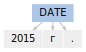

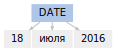

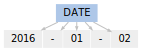

In [17]:
from IPython.display import display

from yargy.predicates import (
    lte,
    gte,
    dictionary
)


MONTHS = {
    'январь',
    'февраль',
    'март',
    'апрель',
    'мая',
    'июнь',
    'июль',
    'август',
    'сентябрь',
    'октябрь',
    'ноябрь',
    'декабрь'
}


MONTH_NAME = dictionary(MONTHS)
MONTH = and_(
    gte(1),
    lte(12)
)
DAY = and_(
    gte(1),
    lte(31)
)
YEAR = and_(
    gte(1900),
    lte(2100)
)
DATE = or_(
    rule(DAY, MONTH_NAME, YEAR),
    rule(YEAR, '-', MONTH, '-', DAY),
    rule(YEAR, 'г', '.')
).named('DATE')
parser = Parser(DATE)
text = '''2015г.
18 июля 2016
2016-01-02
'''
for line in text.splitlines():
    match = parser.match(line)
    display(match.tree.as_dot)

Интерпретация — процесс преобразования дерева разбора в объект с набором полей. Для дат, например, нужно получить структуры вида `Date(year=2016, month=1, day=2)`. Пользователь размечает дерево на вершины-атрибуты и вершины-конструкторы с помощью метода `interpretation`:

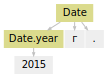

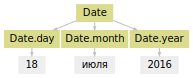

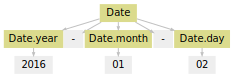

In [18]:
from yargy.interpretation import fact


Date = fact(
    'Date',
    ['year', 'month', 'day']
)


DATE = or_(
    rule(
        DAY.interpretation(
            Date.day
        ),
        MONTH_NAME.interpretation(
            Date.month
        ),
        YEAR.interpretation(
            Date.year
        )
    ),
    rule(
        YEAR.interpretation(
            Date.year
        ),
        '-',
        MONTH.interpretation(
            Date.month
        ),
        '-',
        DAY.interpretation(
            Date.day
        )
    ),
    rule(
        YEAR.interpretation(
            Date.year
        ),
        'г', '.'
    )
).interpretation(
    Date
).named('DATE')

parser = Parser(DATE)
for line in text.splitlines():
    match = parser.match(line)
    display(match.tree.as_dot)

На основании разметки библиотека собирает объекты:

In [19]:
for line in text.splitlines():
    match = parser.match(line)
    display(match.fact)

Date(year='2015',
     month=None,
     day=None)

Date(year='2016',
     month='июля',
     day='18')

Date(year='2016',
     month='01',
     day='02')

## Нормализация

Содержание полей фактов нужно нормировать. Например, не `Date('июня', '2018')`, а `Date(6, 2018)`; не `Person('президента', Name('Владимира', 'Путина'))`, а `Person('президент', Name('Владимир', 'Путин'))`. В Yargy пользователь при разметке дерева разбора указывает, как нормировать вершины-атрибута. Например, здесь слово "июня" будет приведено к нормальной форме "июнь" и заменится на число "6" с помощью словаря `MONTHS`. Год и день просто приводятся к `int`:

In [20]:
MONTHS = {
    'январь': 1,
    'февраль': 2,
    'март': 3,
    'апрель': 4,
    'мая': 5,
    'июнь': 6,
    'июль': 7,
    'август': 8,
    'сентябрь': 9,
    'октябрь': 10,
    'ноябрь': 11,
    'декабрь': 12
}


DATE = rule(
    DAY.interpretation(
        Date.day.custom(int)
    ),
    MONTH_NAME.interpretation(
        Date.month.normalized().custom(MONTHS.get)
    ),
    YEAR.interpretation(
        Date.year.custom(int)
    )
).interpretation(
    Date
)

parser = Parser(DATE)
match = parser.match('18 июня 2016')
match.fact

Date(year=2016,
     month=6,
     day=18)

## Согласование

Пускай есть примитивная грамматика для извлечения имён:

In [21]:
NAME = rule(
    gram('Name').interpretation(
        Name.first.inflected()
    ),
    gram('Surn').interpretation(
        Name.last.inflected()
    )
).interpretation(
    Name
)

У неё есть две проблемы. Она срабатывает на словосочетаниях, где имя и фамилия в разных падежах:

In [22]:
parser = Parser(NAME)
for match in parser.findall('Илье Ивановым, Павлом Семенов'):
    print([_.value for _ in match.tokens])

['Илье', 'Ивановым']
['Павлом', 'Семенов']


Имя и фамилия приводятся к нормальной форме независимо, поэтому, например, фамилия "Иванову" всегда будет мужского рода:

In [23]:
parser = Parser(NAME)
for match in parser.findall('Сашу Иванову, Саше Иванову'):
    display(match.fact)

Name(first='саша',
     last='иванов')

Name(first='саша',
     last='иванов')

In [24]:
from yargy.relations import gnc_relation


gnc = gnc_relation()

NAME = rule(
    gram('Name').interpretation(
        Name.first.inflected()
    ).match(gnc),
    gram('Surn').interpretation(
        Name.last.inflected()
    ).match(gnc)
).interpretation(
    Name
)

In [25]:
parser = Parser(NAME)
for match in parser.findall('Илье Ивановым, Павлом Семенов, Саша Быков'):
    print([_.value for _ in match.tokens])

['Саша', 'Быков']


In [26]:
parser = Parser(NAME)
for match in parser.findall('Сашу Иванову, Саше Иванову'):
    display(match.fact)

Name(first='саша',
     last='иванова')

Name(first='саша',
     last='иванов')